In [177]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import NesterovMomentumOptimizer
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import multiprocessing as mp
import time
import pandas as pd
from datetime import datetime
import os.path

import pytz
# from backports.zoneinfo import ZoneInfo

import warnings
warnings.filterwarnings('ignore')

In [90]:
# Running parameters
num_iters = 300    # Number of training iterations
num_runs = 30

# Circuit and optimization parameters
nqubits = 4         # Num qubits, min 4, always 2**num_layers qubits
with_bias = False    # Add a bias to the output of the quantum circuit
random = True
optimizer = "Adam"  # "Adam", "Nesterov"
loss_type = "cross-entropy" # "projectors", "cross-entropy"

# Data hyper-parameters
batch_size = 100     # batch training size
train_size = 100      # Total ground states that will be used for training
val_size = 1000      # Total gound states with training + validation

# How the training data is generated
uniform_train = False    # True - Uniform, False - Balanced
epsilon_train = True   # True - epsilon, False - no epsilon
uniform_val = True
epsilon_val = False

# Multiprocess hyperparameters. recommended: (num_data, num_cpus) -> (20, 10), (100, 20-30), (200, 40-50) (1000, 50-70)
num_cpus_batch = 30
num_cpus_train = 30
num_cpus_val = 60

# Tweak training hyper-parameters
max_weight_init = 2*np.pi  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.01         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
nweights = 30*(layers-1) + 15

In [91]:
def X(i):
    return qml.PauliX(i)

def Z(i):
    return qml.PauliZ(i)

# Gound states

In [92]:
def ground_state(j1, j2):
    
    hamiltonian = 0
    for i in range(nqubits):
        hamiltonian += Z(i)
        hamiltonian -= j1 * X(i) @ X((i+1)%nqubits)
        hamiltonian -= j2 * X((i-1)%nqubits) @ Z(i) @ X((i+1)%nqubits)
    
    _, eigvecs = np.linalg.eigh(qml.matrix(hamiltonian))
    
    return eigvecs[:,0]

In [93]:
# Define coordinates of the points of each region# Definir las coordenadas de los puntos de cada región
region01_coords = np.array([(-2, 1), (2, 1), (4, 3), (4, 4), (-4, 4), (-4, 3)])    # Class 0
region02_coords = np.array([(-3, -4), (0, -1), (3, -4)])                           # Class 0
region1_coords = np.array([(0, -1), (3, -4), (4, -4), (4, 3)])                     # Class 1
region2_coords = np.array([(0, -1), (-3, -4), (-4, -4), (-4, 3)])                  # Class 2
region3_coords = np.array([(-2, 1), (2, 1), (0, -1)])                              # Class 3

e = 0.2
# Define coordinates of the points of each region far from the borders
region01e_coords = np.array([(-2+(np.sqrt(2)-1)*e, 1+e), (2-(np.sqrt(2)-1)*e, 1+e), (4, 3+np.sqrt(2)*e), (4, 4), (-4, 4), (-4, 3+np.sqrt(2)*e)])    # Class 0 with epsilon
region02e_coords = np.array([(-3+np.sqrt(2)*e, -4), (0, -1-np.sqrt(2)*e), (3-np.sqrt(2)*e, -4)])                                                    # Class 0 with epsilon
region1e_coords = np.array([(0+np.sqrt(2)*e, -1), (3+np.sqrt(2)*e, -4), (4, -4), (4, 3-np.sqrt(2)*e)])                                              # Class 1 with epsilon
region2e_coords = np.array([(0-np.sqrt(2)*e, -1), (-3-np.sqrt(2)*e, -4), (-4, -4), (-4, 3-np.sqrt(2)*e)])                                           # Class 2 with epsilon
region3e_coords = np.array([(-2+e/np.tan(np.pi/8), 1-e), (2-e/np.tan(np.pi/8), 1-e), (0, -1+np.sqrt(2)*e)])                                         # Class 3 with epsilon


def labeling(x, y):

    # Crear objetos Polygon para cada región
    region01_poly = Polygon(region01_coords)
    region02_poly = Polygon(region02_coords)
    region1_poly = Polygon(region1_coords)
    region2_poly = Polygon(region2_coords)
    region3_poly = Polygon(region3_coords)
    
    
    p = Point(x, y)
    if region01_poly.contains(p):
        return 0
    elif region02_poly.contains(p):
        return 0
    elif region1_poly.contains(p):
        return 1
    elif region2_poly.contains(p):
        return 2
    elif region3_poly.contains(p):
        return 3
    else:
        return None # if the point is not in any region
    

def labeling_epsilon(x, y):
    
    # Crear objetos Polygon para cada región
    region01e_poly = Polygon(region01e_coords)
    region02e_poly = Polygon(region02e_coords)
    region1e_poly = Polygon(region1e_coords)
    region2e_poly = Polygon(region2e_coords)
    region3e_poly = Polygon(region3e_coords)
    
    
    p = Point(x, y)
    if region01e_poly.contains(p):
        return 0
    elif region02e_poly.contains(p):
        return 0
    elif region1e_poly.contains(p):
        return 1
    elif region2e_poly.contains(p):
        return 2
    elif region3e_poly.contains(p):
        return 3
    else:
        return None # if the point is not in any region

In [94]:
# Generate ground states
def generate_gs(num_points, uniform, epsilon, num_cpus):

    if random:
        rng = np.random
    else:
        rng = np.random.RandomState(0)
        

    if uniform:
        if epsilon:
            j_list = []
            num = 0
            while num < num_points:
                j = rng.uniform(-4, 4, 2)
                l = labeling_epsilon(j[0], j[1])

                if l in [0,1,2,3]:
                    num += 1
                    j_list.append(j)

            j_list = np.array(j_list)
            
        else:
            j_list = rng.uniform(-4, 4, (num_points,2))
    
    
    else: # Then it's balanced
        npoints_class = num_points//4
        num_points = 4*npoints_class
        
        npoints_01 = npoints_class//2
        npoints_02 = npoints_class - npoints_01
        
        j_list = []
        num_0, num_1, num_2, num_3 = 0, 0, 0, 0
        num_01, num_02 = 0, 0
        
        while num_0 != npoints_class or num_1 != npoints_class or num_2 != npoints_class or num_3 != npoints_class:
            j = rng.uniform(-4, 4, 2)
            l = labeling_epsilon(j[0], j[1]) if epsilon else labeling(j[0], j[1])

            if l==0 and num_0 < npoints_class:
                
                p = Point(j[0], j[1])
                if Polygon(region01_coords).contains(p) and num_01 < npoints_01:
                    num_01 += 1
                    num_0 += 1
                    j_list.append(j)
                elif Polygon(region02_coords).contains(p) and num_02 < npoints_02:
                    num_02 += 1
                    num_0 += 1
                    j_list.append(j)
                
            elif l==1 and num_1 < npoints_class:
                num_1 += 1
                j_list.append(j)
            elif l==2 and num_2 < npoints_class:
                num_2 += 1
                j_list.append(j)
            elif l==3 and num_3 < npoints_class:
                num_3 += 1
                j_list.append(j)

        j_list = np.array(j_list)
    
    
    if num_cpus == 0:
        gs_list = []
        labels_list = []

        for i in range(num_points):
            gs_list.append(ground_state(j_list[i,0], j_list[i,1]))
            labels_list.append(labeling(j_list[i,0], j_list[i,1]))
            
    else:
        args = [[j_list[i,0], j_list[i,1]] for i in range(num_points)]
        
        with mp.Pool(num_cpus) as pool:
            gs_list = pool.starmap(ground_state, args)
        
        with mp.Pool(num_cpus) as pool:
            labels_list = pool.starmap(labeling, args)


    gs_list = np.array(gs_list)
    labels_list = np.array(labels_list)

    return gs_list, labels_list, j_list

# CNN

In [95]:
def convolutional_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

def pooling_layer(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])

In [96]:
def cnn_circuit(weights, state_ini):
    
    qubits = list(range(nqubits))
    
    qml.QubitStateVector(state_ini, wires=qubits)

    for j in range(layers-1):
        
        len_qubits = len(qubits)
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*2*j:15*(2*j+1)])
        
        for i in range(len_qubits//2):
            convolutional_layer(qubits[2*i+1], qubits[(2*i+2)%len_qubits], weights[15*2*j:15*(2*j+1)])
            
        for i in range(len_qubits//2):
            pooling_layer(qubits[2*i], qubits[(2*i+1)%len_qubits], weights[15*(2*j+1):15*(2*j+2)])

        qub = []
        for i in range(len_qubits):
            if i%2 == 1:
                qub.append(qubits[i])
                
        qubits = qub
    
    convolutional_layer(qubits[0], qubits[1], weights[15*(2*layers-2):15*(2*layers-1)])
    
    return qml.expval(Z(qubits[0])), qml.expval(Z(qubits[1])), qml.expval(Z(qubits[0]) @ Z(qubits[1]))

# dev_draw = qml.device("qiskit.aer", wires=nqubits)
dev = qml.device("default.qubit", wires=nqubits)

# cnn_draw = qml.QNode(cnn_circuit, dev_draw)
cnn_circuit = qml.QNode(cnn_circuit, dev, interface="auto", diff_method="best")


def cnn(weights, state_ini):
    z0, z1, zz01 = cnn_circuit(weights, state_ini)

    proj_00 = (1+zz01+z0+z1)/4
    proj_01 = (1-zz01-z0+z1)/4
    proj_10 = (1-zz01+z0-z1)/4
    proj_11 = (1+zz01-z0-z1)/4

    return pnp.array([proj_00, proj_01, proj_10, proj_11])

In [97]:
def variational_classifier(weights, bias, state_ini):
    return cnn(weights, state_ini) + bias

In [98]:
# draw circuit

# weights = np.random.uniform(0, 2*np.pi, nweights)
# drawer = qml.draw(cnn_circuit)
# print(drawer(weights, gs_list[0]))

# z0, z1, zz01 = cnn_draw(gs_list[0], weights)
# print(z0, z1, zz01)
# dev_draw._circuit.draw(output="mpl")

# Loss and accuracy

In [99]:
def log2_arraybox(abox):
    return pnp._np.numpy_boxes.ArrayBox(value = np.log2(abox._value), trace = abox._trace, node = abox._node)


def single_loss(weights, bias, ground_state, label):
    
    proj = variational_classifier(weights, bias, ground_state)

    if loss_type == "projectors":
            cost = proj[label]

    elif loss_type == "cross-entropy":
        
            if isinstance(proj[label], pnp._np.numpy_boxes.ArrayBox):
                cost = -log2_arraybox(proj[label])
            else:
                cost = -np.log2(proj[label])
    
    return cost


def loss(weights, bias, ground_states, labels, num_cpus):
    
    if num_cpus == 0:
        cost = 0

        for j in range(len(labels)):
            cost += single_loss(weights, bias, ground_states[j], labels[j])
    
    else:
        args = [[weights, bias, ground_states[j], labels[j]] for j in range(len(labels))]

        with mp.Pool(num_cpus) as pool:
            cost_arr = pool.starmap(single_loss, args)

        cost = sum(cost_arr)
    
    return cost/len(labels)

In [100]:
def single_pred(weights, bias, ground_state):
    
    projectors = variational_classifier(weights, bias, ground_state)
    
    if loss_type == "projectors":
        pred = np.argmin(projectors)
    elif loss_type == "cross-entropy":
        pred = np.argmax(projectors)

    return pred


def pred(weights, bias, ground_states, num_cpus):
    
    if num_cpus == 0:
        predictions = []
        
        for j in range(len(labels)):
            predictions.append(single_pred(weights, bias, ground_states[j]))
    else:
        args = [[weights, bias, ground_states[j]] for j in range(len(ground_states))]

        with mp.Pool(num_cpus) as pool:
            predictions = pool.starmap(single_pred, args)
            
    return np.array(predictions)


def acc(predictions, labels):
    return sum(predictions==labels)*100/len(labels)

# Training

In [ ]:
if random:
    rng = np.random
else:
    rng = np.random.RandomState(0)


total_weights = []
total_bias = []
total_losses = []
total_pred_train = []
total_pred_val = []
total_acc_train = []
total_acc_val = []
total_it_max = []
total_acc_train_max = []
total_acc_val_max = []
total_j_train = []
total_j_val = []
total_time = []

acc_train_max = 0
run = 0
while acc_train_max < 90 and run < num_runs:
    
    # Generate ground states
    gs_train, labels_train, j_train = generate_gs(train_size, uniform_train, epsilon_train, num_cpus_train)
    gs_val, labels_val, j_val = generate_gs(val_size, uniform_val, epsilon_val, num_cpus_val)

    # weights and bias initialization
    weights_init = pnp.random.uniform(0, max_weight_init, nweights, requires_grad=True)

    if with_bias:
        bias_init = pnp.array([0.0]*4, requires_grad=True)
    else:
        bias_init = np.array([0.0]*4)

    # choose variational classifier
    if optimizer == "Nesterov":
        opt = NesterovMomentumOptimizer(stepsize)
    elif optimizer == "Adam":
        opt = qml.AdamOptimizer(stepsize)

    #Initiaize variables
    
    weights = []
    bias = []
    losses = []
    pred_train_arr = []
    pred_val_arr = []
    acc_train_arr = []
    acc_val_arr = []

    w = weights_init
    b = bias_init

    start_time = time.time()
    
    # Train the QCNN
    for it in range(num_iters):

        batch_index = np.random.randint(0, len(labels_train), (batch_size,))
        gs_train_batch = gs_train[batch_index]
        labels_train_batch = labels_train[batch_index]

        # Update the weights by one optimizer step
        if num_cpus_batch == 0:
            w, b, _, _ = opt.step(loss, w, b, gs_train_batch, labels_train_batch)

        else:
            args = [[single_loss, w, b, gs_train_batch[j], labels_train_batch[j]] for j in range(len(labels_train_batch))]

            with mp.Pool(num_cpus_batch) as pool:
                w, b, _, _ = zip(*pool.starmap(opt.step, args))

            w = sum(w)/len(w)
            b = sum(b)/len(b)

        weights.append(w)
        bias.append(b)

        # Compute predictions and accuracy on train and validation set
        pred_train = pred(w, b, gs_train, num_cpus_train)
        pred_val = pred(w, b, gs_val, num_cpus_val) if len(labels_val) > 0 else None

        acc_train = acc(pred_train, labels_train)
        acc_val = acc(pred_val, labels_val) if len(labels_val) > 0 else 0

        # Save prediction for later plotting
        pred_train_arr.append(pred_train)
        pred_val_arr.append(pred_val)
        acc_train_arr.append(acc_train)
        acc_val_arr.append(acc_val)

        l = loss(w, b, gs_train, labels_train, num_cpus_train)
        losses.append(l)
    
    
    run_time = time.time()-start_time
    
    it_max = np.argmax(np.array(acc_train_arr))
    acc_train_max = acc_train_arr[it_max]
    acc_val_max = acc_val_arr[it_max]
    
    total_weights.append(weights)
    total_bias.append(bias)
    total_losses.append(losses)
    total_pred_train.append(pred_train_arr)
    total_pred_val.append(pred_val_arr)
    total_acc_train.append(acc_train_arr)
    total_acc_val.append(acc_val_arr)
    total_it_max.append(it_max)
    total_acc_train_max.append(acc_train_max)
    total_acc_val_max.append(acc_val_max)
    total_j_train.append(j_train)
    total_j_val.append(j_val)
    total_time.append(run_time)
    
    print(
        "Run: {:3d} | Iter: {:3d} | Loss: {:0.4f} | Acc train: {:0.2f} | Acc val: {:0.2f} | Time: {:0.0f}"
        "".format(run, it_max, losses[it_max], acc_train_arr[it_max], acc_val_arr[it_max], run_time)
    )
    run += 1

run_max = np.argmax(np.array(total_acc_train_max))
it_max_run_max = total_it_max[run_max]

avg_acc_train_max = sum(total_acc_train_max)/len(total_acc_train_max)
avg_acc_val_max = sum(total_acc_val_max)/len(total_acc_val_max)

last_run = len(total_it_max)-1
last_iter = len(total_losses[0])-1

avg_acc_train_last = np.mean(np.array(total_acc_train)[:,last_iter])
avg_acc_val_last = np.mean(np.array(total_acc_val)[:,last_iter])


print(
    "Max acc_train / Acc last_run -> Run: {:3d}/{:3d} | Iter: {:3d}/{:3d} | Acc train: {:0.2f}/{:0.2f} | Acc val: {:0.2f}/{:0.2f} || Averages -> Acc train {:0.2f}/{:0.2f} | Acc val {:0.2f}/{:0.2f}"
    "".format(run_max, last_run, it_max_run_max, last_iter, total_acc_train[run_max][it_max_run_max], total_acc_train[last_run][last_iter], total_acc_val[run_max][it_max_run_max], total_acc_val[last_run][last_iter], avg_acc_train_max, avg_acc_train_last, avg_acc_val_max, avg_acc_val_last)
)

# Processing Data

In [183]:
# time_now = datetime.now(ZoneInfo("Europe/Madrid")).strftime("%Y-%m-%d %H-%M-%S")
time_now = datetime.now(pytz.timezone('Europe/Andorra')).strftime("%Y-%m-%d %H-%M-%S")

folder_name = f"Results/{nqubits}q - {num_iters:} iters/no_qurriculum"
if not os.path.isdir(f'{folder_name}'):
    os.makedirs(f'{folder_name}')

ut = "unif-T" if uniform_train else "no-unif-T"
et = "eps-T" if epsilon_train else "no-eps-T"
uv = "unif-V" if uniform_val else "no-unif-V"
ev = "eps-V" if epsilon_val else "no-eps-V"

file_name = f'{train_size:4d} Train - {val_size:5d} Val, {ut}, {et}, {uv}, {ev}'


data = {}
data["total_weights"] = total_weights
data["total_bias"] = total_bias
data["total_losses"] = total_losses
data["total_pred_train"] = total_pred_train
data["total_pred_val"] = total_pred_val
data["total_acc_train"] = total_acc_train
data["total_acc_val"] = total_acc_val
data["total_it_max"] = total_it_max
data["total_acc_train_max"] = total_acc_train_max
data["total_acc_val_max"] = total_acc_val_max
data["total_j_train"] = total_j_train
data["total_j_val"] = total_j_val
data["total_time"] = total_time

data = pd.DataFrame(data)

data_file_name = f"{time_now} - Data - {file_name}"
data.to_csv(f'{folder_name}/{data_file_name}.csv', index=False)


hyperparameters = {}
hyperparameters["num_iters"] = [num_iters]
hyperparameters["num_runs"] = [num_runs]
hyperparameters["nqubits"] = [nqubits]
hyperparameters["with_bias"] = [with_bias]
hyperparameters["random"] = [random]
hyperparameters["optimizer"] = [optimizer]
hyperparameters["loss_type"] = [loss_type]
hyperparameters["batch_size"] = [batch_size]
hyperparameters["train_size"] = [train_size]
hyperparameters["val_size"] = [val_size]
hyperparameters["uniform_train"] = [uniform_train]
hyperparameters["epsilon_train"] = [epsilon_train]
hyperparameters["uniform_val"] = [uniform_val]
hyperparameters["epsilon_val"] = [epsilon_val]
hyperparameters["num_cpus_batch"] = [num_cpus_batch]
hyperparameters["num_cpus_train"] = [num_cpus_train]
hyperparameters["num_cpus_val"] = [num_cpus_val]
hyperparameters["max_weight_init"] = [max_weight_init]
hyperparameters["stepsize"] = [stepsize]

hyperparameters = pd.DataFrame(hyperparameters)

hyperparameters_file_name = f"{time_now} - Hyperparameters - {file_name}"
hyperparameters.to_csv(f'{folder_name}/{hyperparameters_file_name}.csv', index=False)



results = {}
results["max_acc_train"] = [total_acc_train[run_max][it_max_run_max]]
results["acc_val"] = [total_acc_val[run_max][it_max_run_max]]
results["avg_acc_train_max"] = [avg_acc_train_max]
results["avg_acc_train_last"] = [avg_acc_train_last]
results["avg_acc_val_max"] = [avg_acc_val_max]
results["avg_acc_val_last"] = [avg_acc_val_last]

results = pd.DataFrame(results)

results_file_name = f"{time_now} - Results - {file_name}"
results.to_csv(f'{folder_name}/{results_file_name}.csv', index=False)

print("Done!")

In [ ]:
### # Copy data from file

# run_max = np.argmax(np.array(total_acc_train_max))
# it_max_run_max = total_it_max[run_max]

# avg_acc_train_max = sum(total_acc_train_max)/len(total_acc_train_max)
# avg_acc_val_max = sum(total_acc_val_max)/len(total_acc_val_max)

# Plotting

In [175]:
print("Max train / Last run")
print("---------------------------------------")
print("Run |  Iter   |Acc train|Acc val| Time ")
print("---------------------------------------")

for info_run in range(num_runs):
    
    info_it_max = total_it_max[info_run]
    
    print(
        f"{info_run:3d} |"
        f" {info_it_max:3d}/{last_iter:3d} |"
        f"  {total_acc_train[info_run][info_it_max]:0.0f}/{total_acc_train[info_run][last_iter]:0.0f}  |"
        f" {total_acc_val[info_run][info_it_max]:0.0f}/{total_acc_val[info_run][last_iter]:0.0f} |"
        f" {total_time[info_run]:0.0f}"
    )

print(
    f"Max/Last -> "
    f"Run: {run_max:3d}/{last_run:3d} | "
    f"Iter: {it_max_run_max:3d}/{last_iter:3d} | "
    f"Acc train: {total_acc_train[run_max][it_max_run_max]:0.0f}/{total_acc_train[last_run][last_iter]:0.0f} | "
    f"Acc val: {total_acc_val[run_max][it_max_run_max]:0.0f}/{total_acc_val[last_run][last_iter]:0.0f} || "
)
print(
    f"Averages -> "
    f"Acc train {avg_acc_train_max:0.0f}/{avg_acc_train_last:0.0f} | "
    f"Acc val {avg_acc_val_max:0.0f}/{avg_acc_val_last:0.0f}"
)

Max train / Last run
---------------------------------------
Run |  Iter   |Acc train|Acc val| Time 
---------------------------------------
  0 | 127/299 |  87/71  | 72/60 | 1100
  1 | 153/299 |  72/65  | 74/52 | 1129
  2 | 180/299 |  80/69  | 71/73 | 1141
  3 | 264/299 |  74/74  | 50/50 | 1125
  4 | 299/299 |  71/71  | 77/77 | 1101
  5 | 195/299 |  73/72  | 51/51 | 1111
  6 | 198/299 |  65/62  | 69/69 | 1114
  7 | 206/299 |  86/80  | 72/57 | 1128
  8 | 298/299 |  79/79  | 65/65 | 1135
  9 | 212/299 |  84/79  | 79/69 | 1108
 10 | 132/299 |  79/71  | 57/59 | 1124
 11 |  72/299 |  79/69  | 83/51 | 1127
 12 | 111/299 |  86/76  | 80/59 | 1148
 13 |  29/299 |  79/70  | 73/53 | 1135
 14 | 159/299 |  81/73  | 65/57 | 1141
 15 |  60/299 |  71/56  | 58/63 | 1161
 16 | 136/299 |  73/71  | 55/54 | 1154
 17 | 156/299 |  81/73  | 72/50 | 1158
 18 | 116/299 |  74/71  | 54/54 | 1151
 19 |  81/299 |  75/67  | 77/70 | 1156
 20 | 224/299 |  73/71  | 53/53 | 1168
 21 | 107/299 |  77/69  | 54/52 | 1189
 

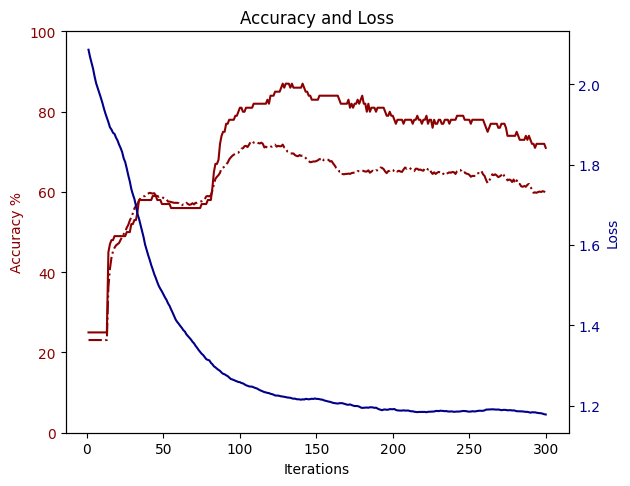

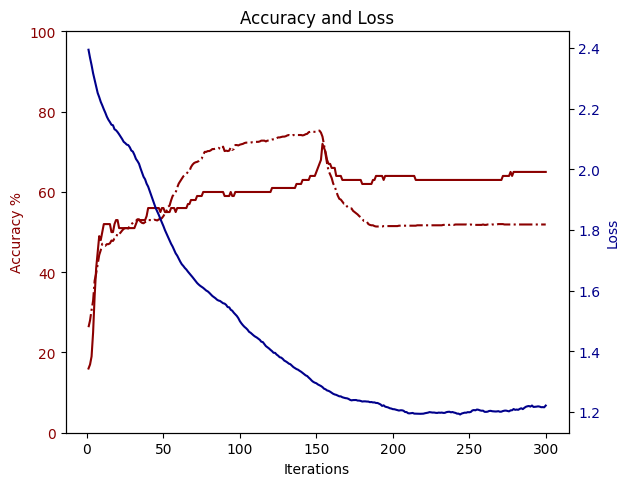

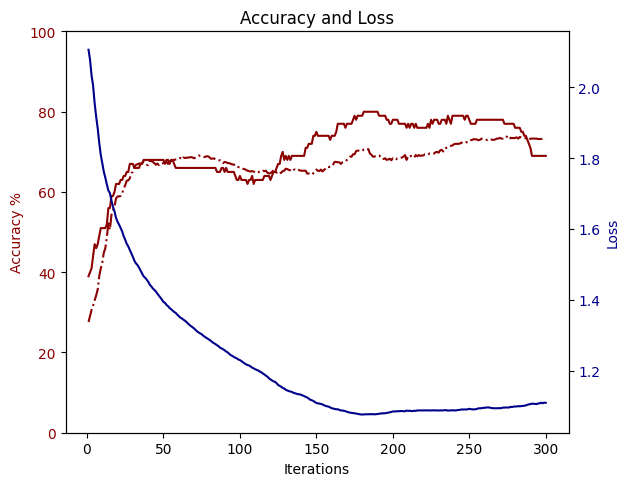

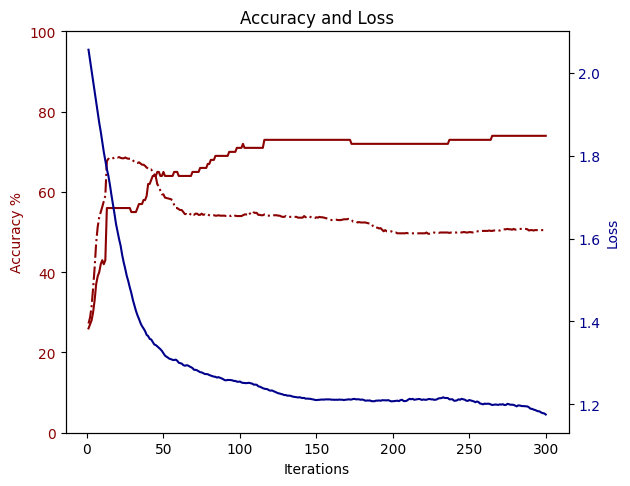

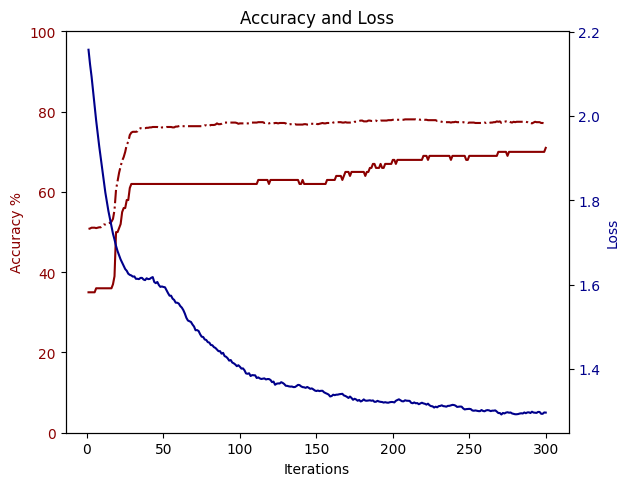

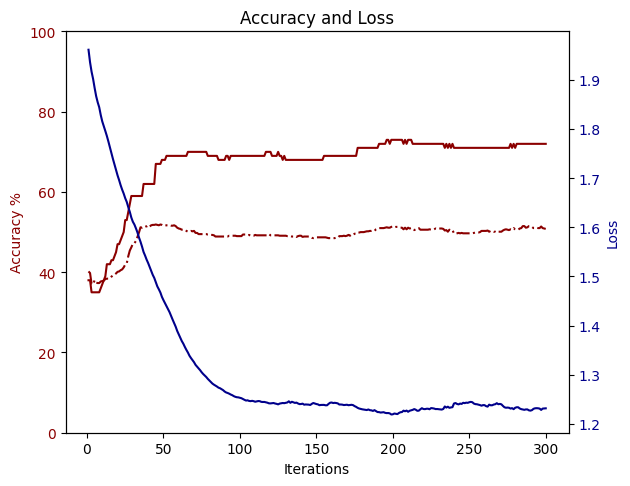

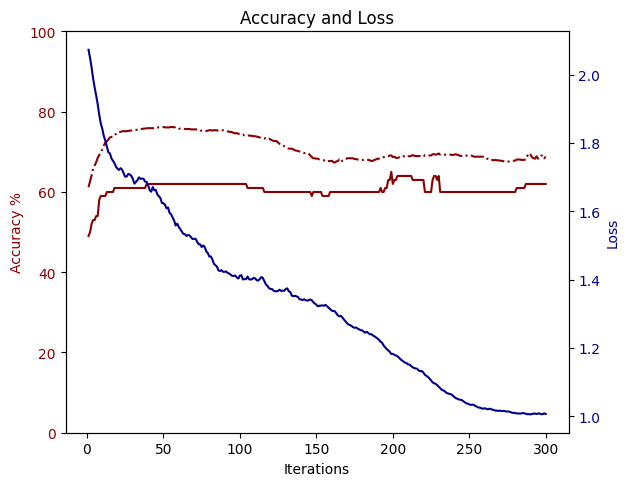

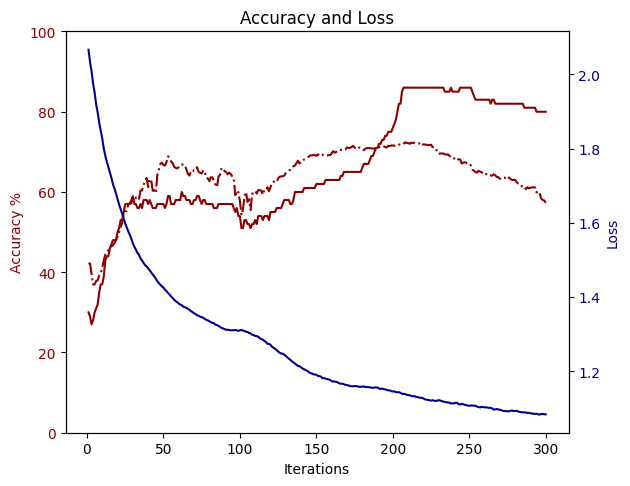

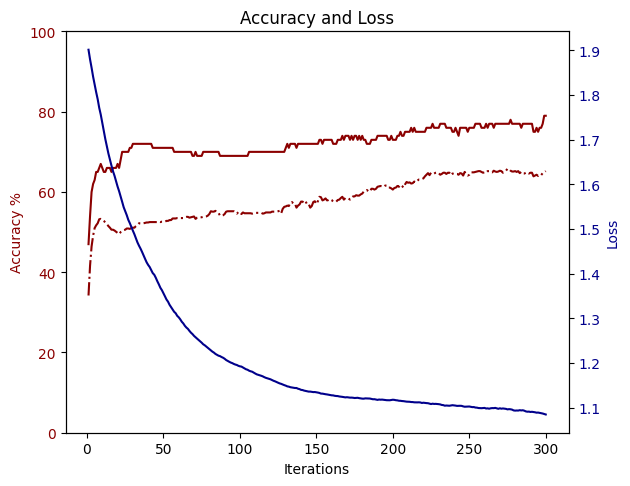

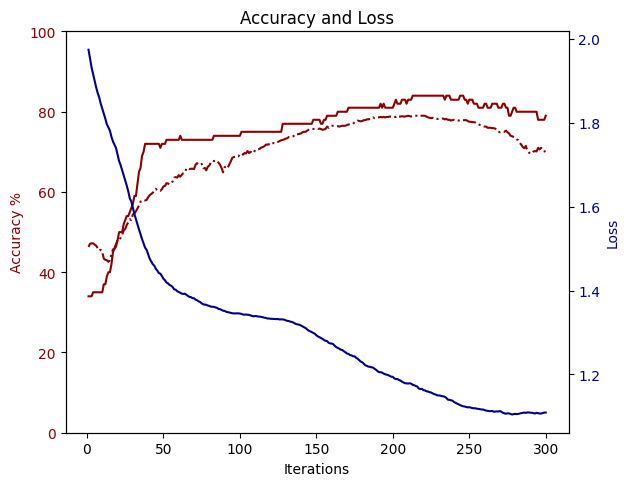

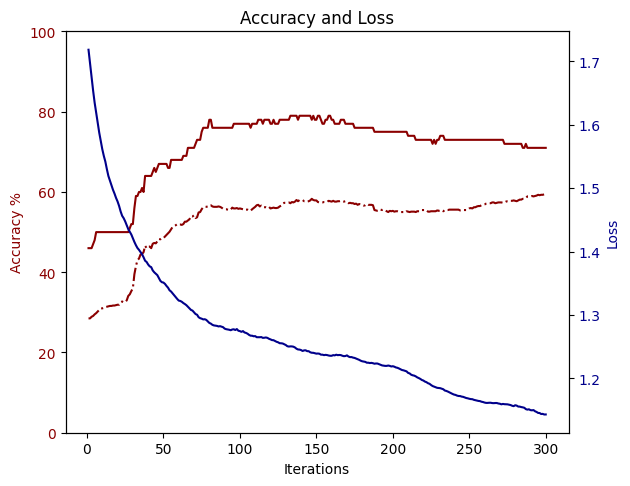

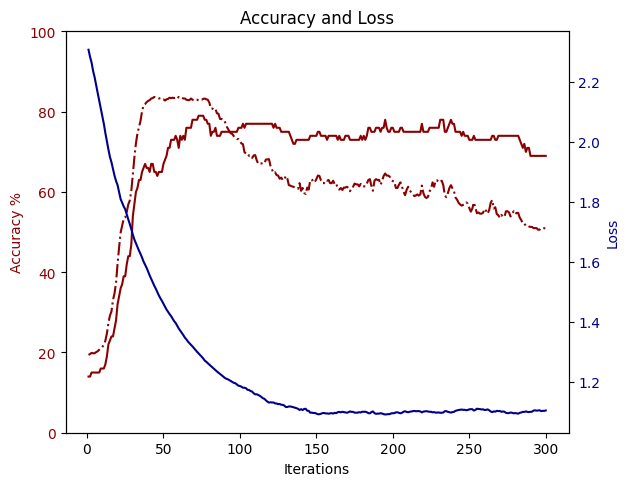

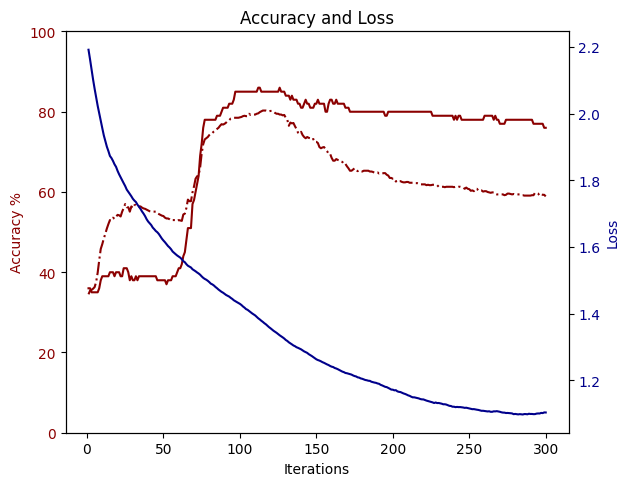

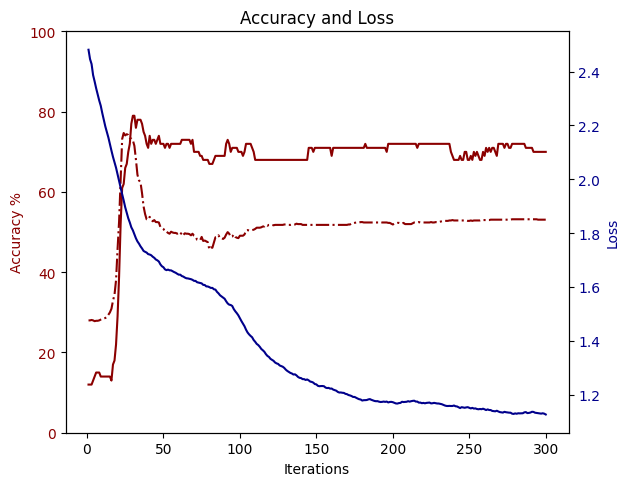

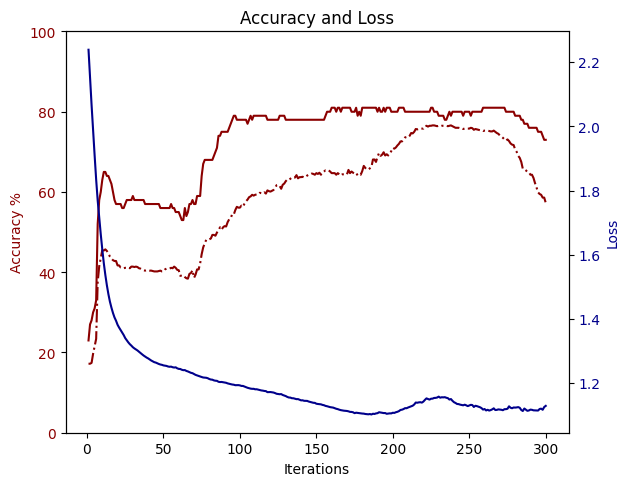

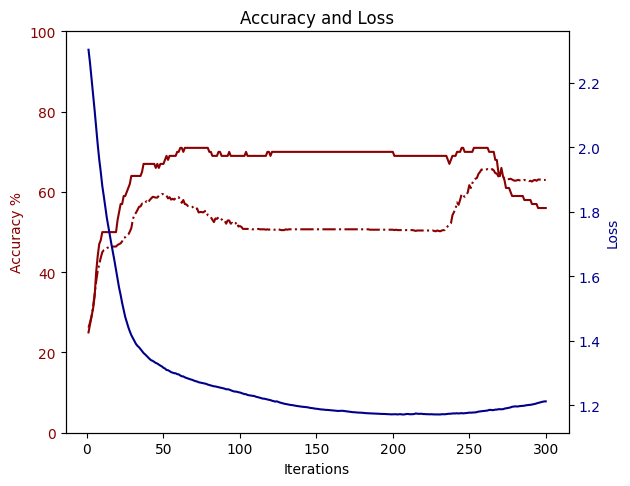

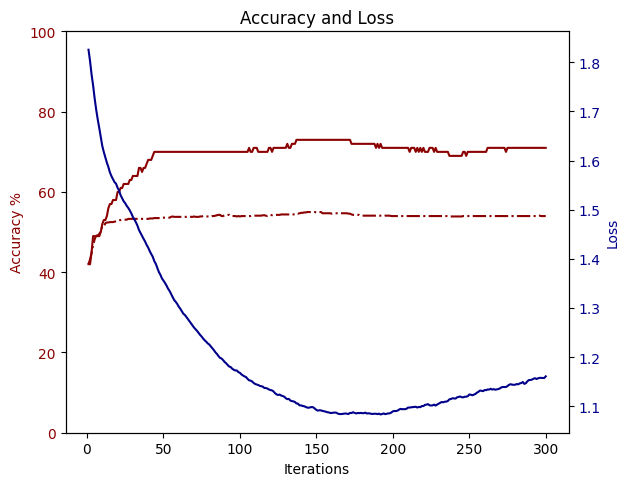

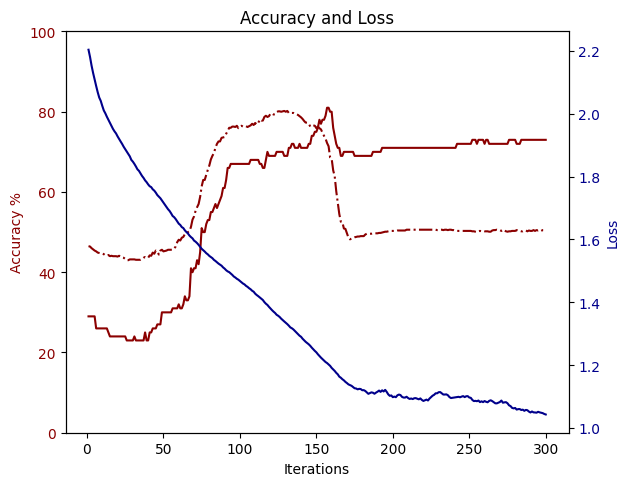

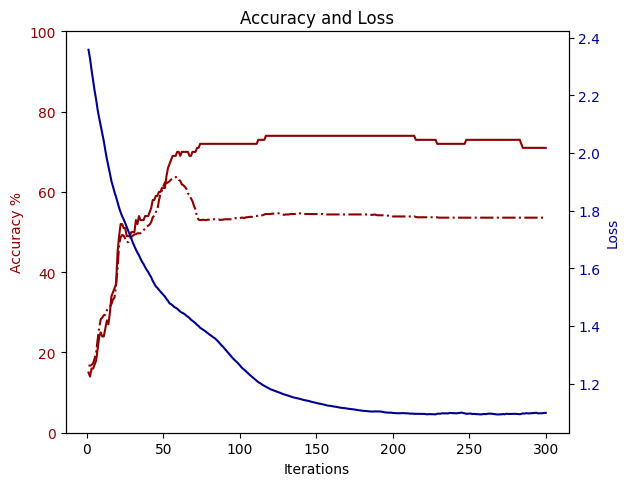

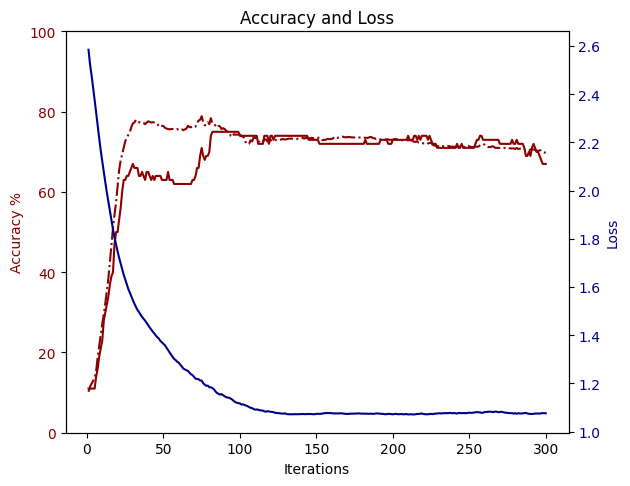

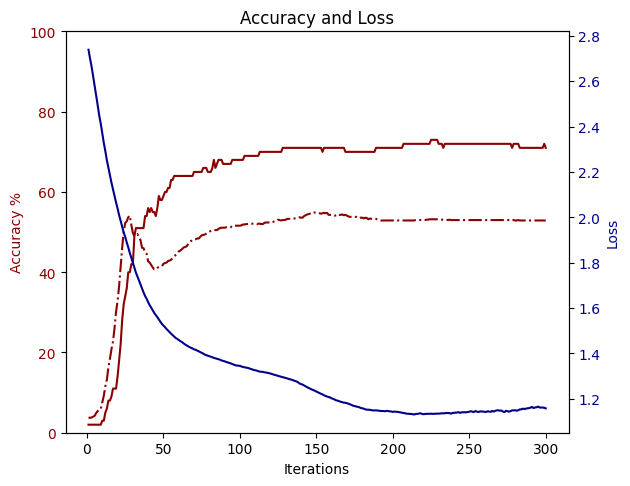

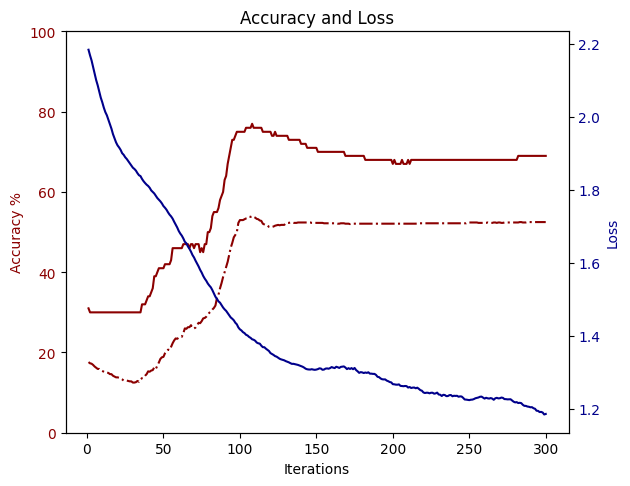

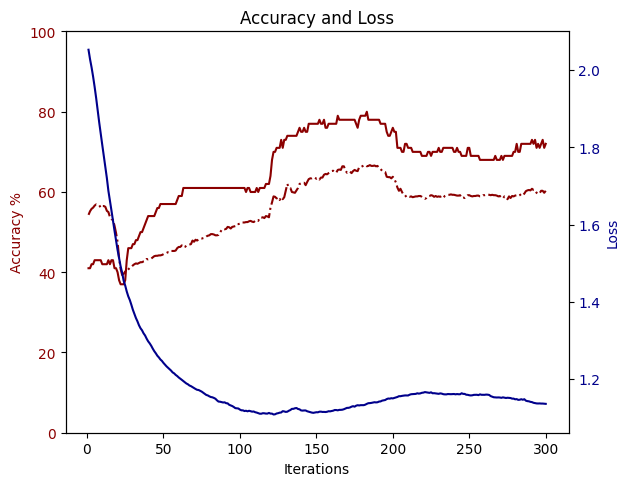

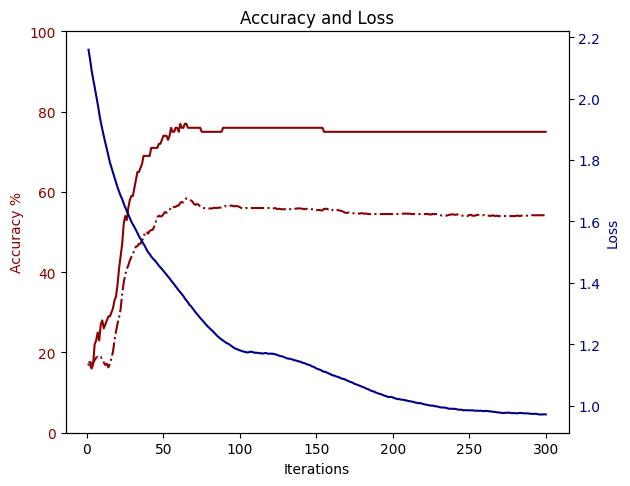

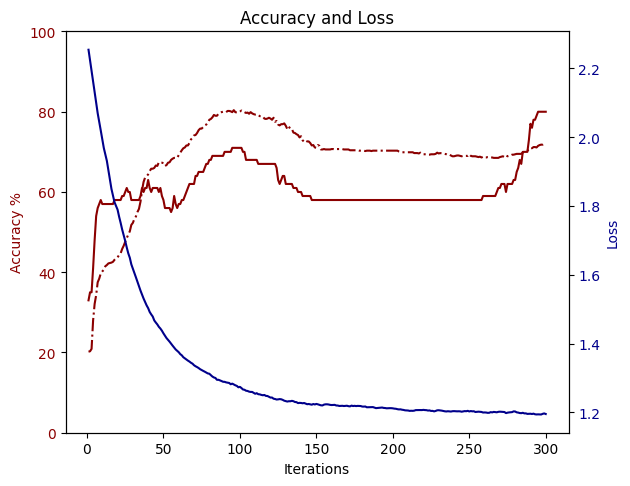

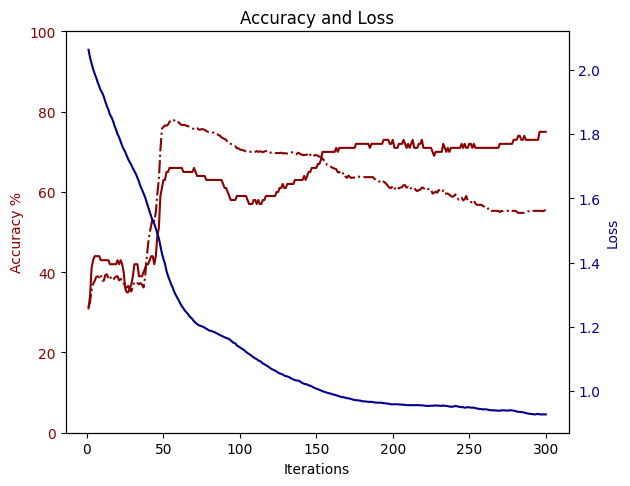

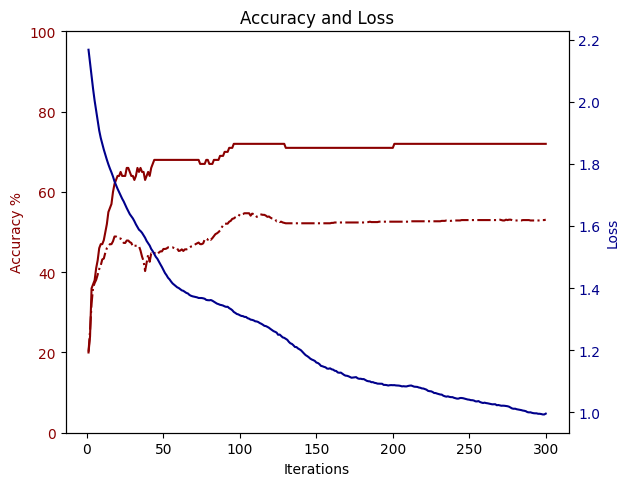

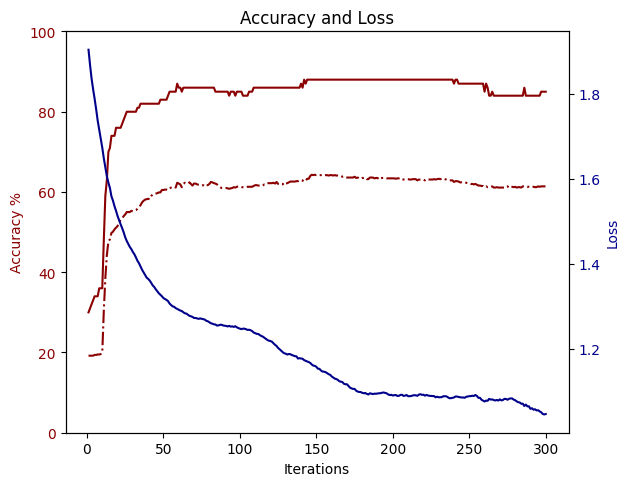

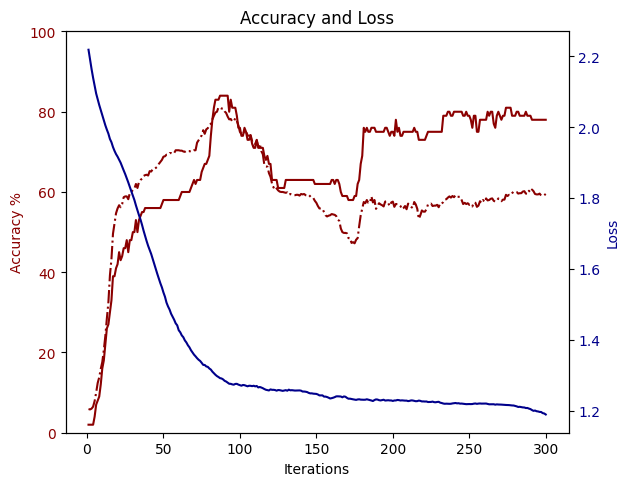

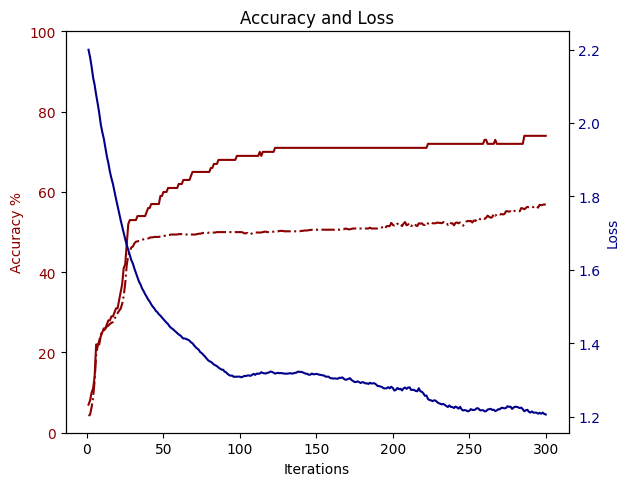

In [122]:
for plot_run in range(num_runs):

# plot_run = 4# run_max

    acc_train_arr = total_acc_train[plot_run]
    acc_val_arr = total_acc_val[plot_run]
    losses = total_losses[plot_run]

    iterations = range(1, len(acc_train_arr)+1)
    fig, ax1 = plt.subplots()

    color1 = 'darkred'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Accuracy %', color=color1)
    ax1.plot(iterations, acc_train_arr, label="Training", color=color1)
    ax1.plot(iterations, acc_val_arr, '-.', label="Validation", color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylim(0,100)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'darkblue'
    ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with ax1
    ax2.plot(iterations, losses, label="Loss", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    # ax2.set_ylim(bottom=0)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.legend()
    plt.title("Accuracy and Loss")
    plt.show()

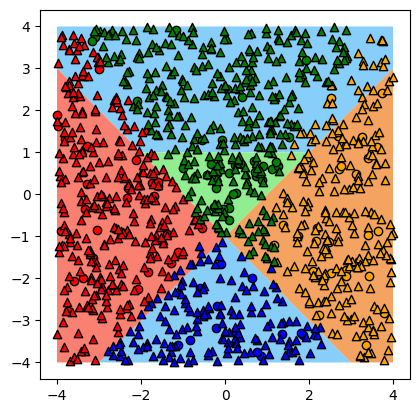

In [139]:
plot_run = run_max # run_max

plot_iter = total_it_max[plot_run]
pred_train_arr = total_pred_train[plot_run]
pred_val_arr = total_pred_val[plot_run]
j_train = total_j_train[plot_run]
j_val = total_j_val[plot_run]

# define regions coordinates
x01, y01 = region01_coords[:,0], region01_coords[:,1]
x02, y02 = region02_coords[:,0], region02_coords[:,1]
x1, y1 = region1_coords[:,0], region1_coords[:,1]
x2, y2 = region2_coords[:,0], region2_coords[:,1]
x3, y3 = region3_coords[:,0], region3_coords[:,1]

# plt.figure(figsize=(8, 8))

# put the regions into the plot
plt.fill(x01, y01, facecolor='lightskyblue')    # class 0
plt.fill(x02, y02, facecolor='lightskyblue')    # class 0
plt.fill(x1, y1, facecolor='sandybrown')        # class 1
plt.fill(x2, y2, facecolor='salmon')            # class 2
plt.fill(x3, y3, facecolor='lightgreen')        # class 3

pred_train_plot = np.array(pred_train_arr[plot_iter])
pred_val_plot = np.array(pred_val_arr[plot_iter])

colors = ["b", "orange", "r", "g"]

# plot datapoints
for i in range(4):
    plt.scatter(
        j_train[:, 0][pred_train_plot==i],
        j_train[:, 1][pred_train_plot==i],
        c=colors[i],
        marker="o",
        edgecolors="k",
        label=f"class {i+1} train",
    )
    plt.scatter(
        j_val[:, 0][pred_val_plot==i],
        j_val[:, 1][pred_val_plot==i],
        c=colors[i],
        marker="^",
        edgecolors="k",
        label=f"class {i+1} validation",
    )


# plt.legend()
plt.axis('square')
plt.show()

In [ ]:
# print(mp.cpu_count()) #256

gs = gs_train
lab = labels_train

for i in range(10, 120, 10):
    num_cpus_test = i
    start_time = time.time()
    loss(w, b, gs, lab, num_cpus_test)
    print(f"{i} --- {(time.time() - start_time):.2f} seconds ---")

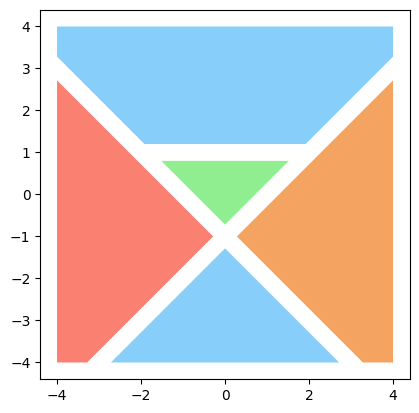

In [112]:
# define regions coordinates
x01, y01 = region01e_coords[:,0], region01e_coords[:,1]
x02, y02 = region02e_coords[:,0], region02e_coords[:,1]
x1, y1 = region1e_coords[:,0], region1e_coords[:,1]
x2, y2 = region2e_coords[:,0], region2e_coords[:,1]
x3, y3 = region3e_coords[:,0], region3e_coords[:,1]

# put the regions into the plot
plt.fill(x01, y01, facecolor='lightskyblue')    # class 0
plt.fill(x02, y02, facecolor='lightskyblue')    # class 0
plt.fill(x1, y1, facecolor='sandybrown')        # class 1
plt.fill(x2, y2, facecolor='salmon')            # class 2
plt.fill(x3, y3, facecolor='lightgreen')        # class 3

plt.axis('square')
plt.show()